In [1]:
#Monte Carlo ES
import numpy as np
import random as rnd
from blackjack_env import BlackJackEnv, CARD_INDX
CARDS = ["Ace", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine", "Ten", "Queen", "Jack", "King"]
CARDS_L = ["Ace", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine", "Ten"]

def mc_es(gamma, runs = 10000):
    policy = np.random.randint(0, 2, size=(10,10,2))
    action_val = np.zeros(shape=(10,10,2,2))
    returns = [[[[[] for _ in range(2)] for _ in range(2)] for _ in range(10)] for _ in range(10)]

    bj = BlackJackEnv()    

    for _ in range(runs):
        episode = bj.run_episode(policy) #Returns a list of tuples (state, action, reward)
        g = 0
        seen_states = []
        for i in reversed(range(len(episode))):
            g = g * gamma + episode[i][2]
            state_action_pair = (episode[i][0], episode[i][1])

            act = episode[i][1]
            aces = episode[i][0]['usable_aces']
            dealer = CARD_INDX[episode[i][0]['dealer_card']]
            player = episode[i][0]['hand_sum'] - 12

            if state_action_pair not in seen_states:
                seen_states.append(state_action_pair)
                returns[player][dealer][aces][act].append(g)
                action_val[player][dealer][aces][act] = np.mean(returns[player][dealer][aces][act])

                q_values_for_state = [action_val[player][dealer][aces][0], action_val[player][dealer][aces][1]]
                policy[player][dealer][aces] = np.argmax(q_values_for_state)

    return action_val, policy

In [5]:
action_val, policy = mc_es(1, 500000) #500k runs 5m 29s

policy_dealer = np.zeros(shape=(10,10,2))

for player_sum_idx in range(10): # simulating dealers policy
    actual_player_sum = player_sum_idx + 12
    for dealer_card_idx in range(10):
        for usable_ace_idx in range(2):
            if actual_player_sum >= 17:
                policy_dealer[player_sum_idx][dealer_card_idx][usable_ace_idx] = 1 # Stick
            else:
                policy_dealer[player_sum_idx][dealer_card_idx][usable_ace_idx] = 0 # Hit

In [6]:
bjtable = BlackJackEnv()

for pol in [policy, policy_dealer]:
    w = 0
    d = 0
    l = 0
    for _ in range(100000):
        episode = bjtable.run_episode(pol)
        match episode[-1][2]:
            case 1:
                w += 1
            case 1.5:
                w += 1.5
            case 0:
                d += 1
            case -1:
                l += 1

    print((w-l)/100000)

-0.22067
-0.223915


C:\Users\ati-04\AppData\Local\Temp\ipykernel_7444\759597906.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1[1].legend()


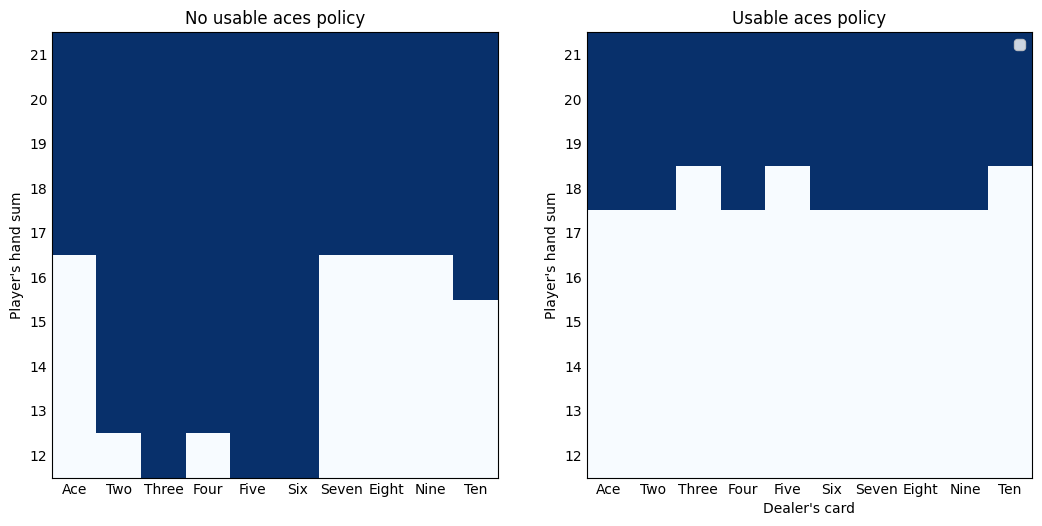

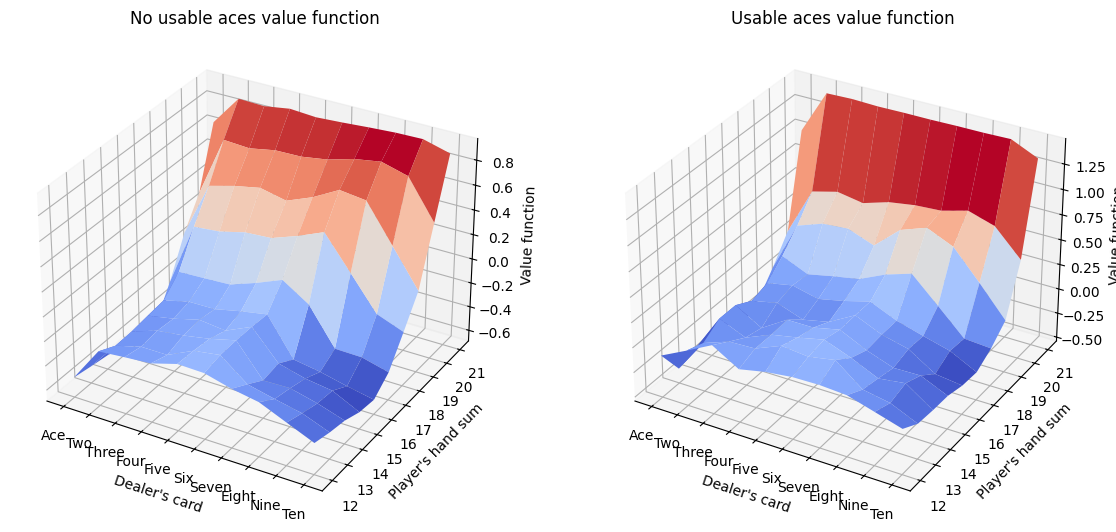

In [8]:
import matplotlib.pyplot as plt

plt.style.use('_mpl-gallery-nogrid')

for pol_used in [policy]:

    n_usable_ace = [[pol_used[i][j][0] for j in range(10)] for i in range(10)]
    usable_ace = [[pol_used[i][j][1] for j in range(10)] for i in range(10)]
    state_values_noace = np.array([[action_val[i][j][0][pol_used[i][j][0]] for j in range(10)] for i in range(10)])
    state_values_ace = np.array([[action_val[i][j][1][pol_used[i][j][1]] for j in range(10)] for i in range(10)])

    fig1, ax1 = plt.subplots(1,2, figsize=(10,8))

    ax1[0].imshow(n_usable_ace, origin='lower')
    ax1[0].set_title("No usable aces policy")
    ax1[0].set_xticks(np.arange(0,10))
    ax1[0].set_yticks(np.arange(0,10))
    ax1[0].set_xticklabels(CARDS_L)
    ax1[0].set_yticklabels(np.arange(12,22))
    ax1[0].set_ylabel("Dealer's card")
    ax1[0].set_ylabel("Player's hand sum")

    ax1[1].imshow(usable_ace, origin='lower')
    ax1[1].set_title("Usable aces policy")
    ax1[1].set_xticks(np.arange(0,10))
    ax1[1].set_yticks(np.arange(0,10))
    ax1[1].set_xticklabels(CARDS_L)
    ax1[1].set_yticklabels(np.arange(12,22))
    ax1[1].set_xlabel("Dealer's card")
    ax1[1].set_ylabel("Player's hand sum")
    ax1[1].legend()

    plt.show()

    player_sum = np.arange(12, 22)
    dealer_card = np.arange(1, 11)
    X, Y = np.meshgrid(dealer_card, player_sum)

    fig2 = plt.figure(figsize=(11,9))
    ax2_0 = fig2.add_subplot(1,2,1,projection='3d')
    ax2_1 = fig2.add_subplot(1,2,2,projection='3d')

    ax2_0.plot_surface(X,Y,state_values_noace, cmap='coolwarm')
    ax2_0.set_title("No usable aces value function")
    ax2_0.set_xticks(np.arange(1, 11))
    ax2_0.set_xticklabels(CARDS_L)
    ax2_0.set_xlabel("Dealer's card")
    ax2_0.set_yticks(np.arange(12,22))
    ax2_0.set_yticklabels(np.arange(12,22))
    ax2_0.set_ylabel("Player's hand sum")
    ax2_0.set_zlabel("Value function")
    
    ax2_1.plot_surface(X,Y,state_values_ace, cmap='coolwarm')
    ax2_1.set_title("Usable aces value function")
    ax2_1.set_xticks(np.arange(1, 11))
    ax2_1.set_xticklabels(CARDS_L)
    ax2_1.set_xlabel("Dealer's card")
    ax2_1.set_yticks(np.arange(12,22))
    ax2_1.set_yticklabels(np.arange(12,22))
    ax2_1.set_ylabel("Player's hand sum")
    ax2_1.set_zlabel("Value function")

    plt.show()
